In [1]:
!pip install matplotlib

In [2]:
!pip install timm

In [3]:
!pip install transformers

  Using cached transformers-4.48.3-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.48.3-py3-none-any.whl (9.7 MB)


In [4]:
!pip install pytorch torchvision torchaudio

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\SMHRD\AppData\Local\Temp\pip-install-2dut4mye\pytorch_48446652d9634d24bc4c59beb85cb0a0\setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [5]:
!pip install timm

In [6]:
import os
import torch
from transformers import AutoImageProcessor, AutoModelForObjectDetection, pipeline
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [7]:
import sys
import site
print("📂 Python 환경의 패키지 경로 목록:")
for path in sys.path:

    print(path)

📂 Python 환경의 패키지 경로 목록:
c:\Users\SMHRD\Desktop\5g\5G\back\projectmodel\project_model\image_segmentation
c:\Users\SMHRD\anaconda3\python312.zip
c:\Users\SMHRD\anaconda3\DLLs
c:\Users\SMHRD\anaconda3\Lib
c:\Users\SMHRD\anaconda3

C:\Users\SMHRD\AppData\Roaming\Python\Python312\site-packages
c:\Users\SMHRD\anaconda3\Lib\site-packages
c:\Users\SMHRD\anaconda3\Lib\site-packages\win32
c:\Users\SMHRD\anaconda3\Lib\site-packages\win32\lib
c:\Users\SMHRD\anaconda3\Lib\site-packages\Pythonwin


In [8]:
import timm
print(timm.__version__)

1.0.14


In [9]:
# 프로젝트 디렉토리 설정
WorkDir = "C:\\Users\\SMHRD\\Desktop\\5g\\5G\\back\\projectmodel\\project_model\\image_segmentation"
img_dir = os.path.join(WorkDir, 'crawled_images')
output_dir = os.path.join(WorkDir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [10]:
# 모델 로드
model_name = "yainage90/fashion-object-detection"

# 모델과 프로세서 로드
processor = AutoImageProcessor.from_pretrained(model_name, force_download=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
model = AutoModelForObjectDetection.from_pretrained(model_name, force_download = True).to(device)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

In [12]:
# 이미지 파일 확인 및 처리
image_path = os.path.join(img_dir, 'image_1384.jpg')
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found: {image_path}")

image = Image.open(image_path)


In [13]:
# 입력 변환 및 디바이스 적용
inputs = processor(images=image, return_tensors="pt").to(device)

In [14]:
# 모델 예측 수행
start_time = time.time()
with torch.no_grad():
    outputs = model(**inputs)

print("Execution Time:", time.time() - start_time)

Execution Time: 4.0642454624176025


In [15]:
# 결과 후처리
target_sizes = torch.tensor([[image.size[1], image.size[0]]]).to(device)
results = processor.post_process_object_detection(outputs, threshold=0.4, target_sizes=target_sizes)[0]

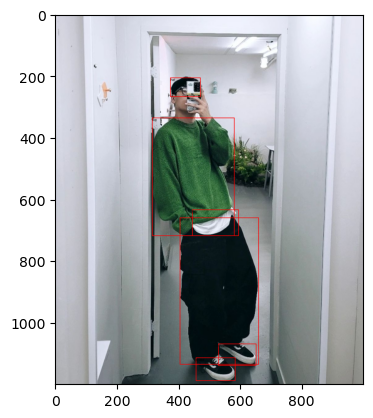

In [16]:
# 결과 출력 및 시각화
draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    score = score.item()
    label = label.item()
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=2)
    draw.text((x, y), model.config.id2label[label], fill="black")

plt.imshow(image)
plt.show()

In [ ]:
# 객체 감지 및 크롭 저장
target_labels = ['top', 'outer', 'bottom', 'dress']

# 여러 이미지 처리
for f in tqdm(os.listdir(img_dir)):
    if f.endswith('.jpg'):
        img_id = f.split('.')[0]
        image = Image.open(os.path.join(img_dir, f))
        w, h = image.size
        threshold_size = int(w * h * 0.05)  # 최소 5% 이상 크기인 객체만 저장

        # 이미지 변환 및 추론
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        # 결과 후처리
        target_sizes = torch.tensor([[h, w]]).to(device)
        results = processor.post_process_object_detection(outputs, threshold=0.4, target_sizes=target_sizes)[0]

        # 감지된 객체 크롭 및 저장
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            label_name = model.config.id2label[label.item()]
            if label_name in target_labels:
                box = [round(i, 2) for i in box.tolist()]
                x, y, x2, y2 = tuple(box)

                cropped = image.crop((x, y, x2, y2))
                if cropped.width * cropped.height >= threshold_size:
                    cropped.save(os.path.join(output_dir, f'{img_id}_{label_name}.jpg'))

print("Cropping & Saving Completed")

100%|██████████| 3112/3112 [2:03:34<00:00,  2.38s/it]  

Cropping & Saving Completed
